In this series of notebooks, we demonstrate some useful patterns and recipes for visualizing animating optimization algorithms using Matplotlib.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

We shall restrict our attention to 3-dimensional problems for right now (i.e. optimizing over only 2 parameters), though what follows can be extended to higher dimensions by plotting all pairs of parameters against each other, effectively projecting the problem to 3-dimensions. 

The Wikipedia article on [Test functions for optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization) has a few functions that are useful for evaluating optimization algorithms. In particular, we shall look at **Beale's function**:

$$
f(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2
$$

In [3]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

<!-- TEASER_END -->

In [4]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

In [5]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [6]:
z = f(x, y)

We know the global minima is at $(3, 0.5)$

In [7]:
minima = np.array([3., .5])

In [8]:
f(*minima)

0.0

In [9]:
minima_ = minima.reshape(-1, 1)
minima_

array([[3. ],
       [0.5]])

In [10]:
f(*minima_)

array([0.])

### 3D Surface Plot

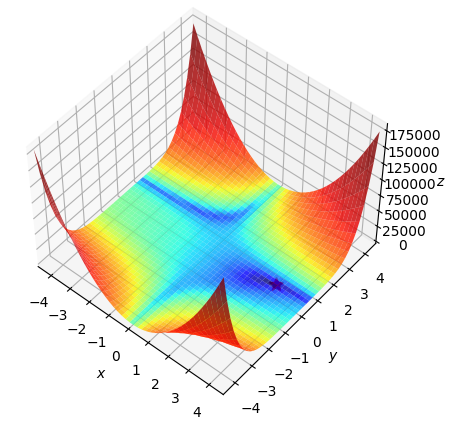

In [11]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

### 2D Contour Plot and Gradient Vector Field

We use [autograd](https://github.com/HIPS/autograd) to compute the gradient vector field, and plot it with Matplotlib's [quiver](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.quiver) method.

In [12]:
dz_dx = elementwise_grad(f, argnum=0)(x, y)
dz_dy = elementwise_grad(f, argnum=1)(x, y)

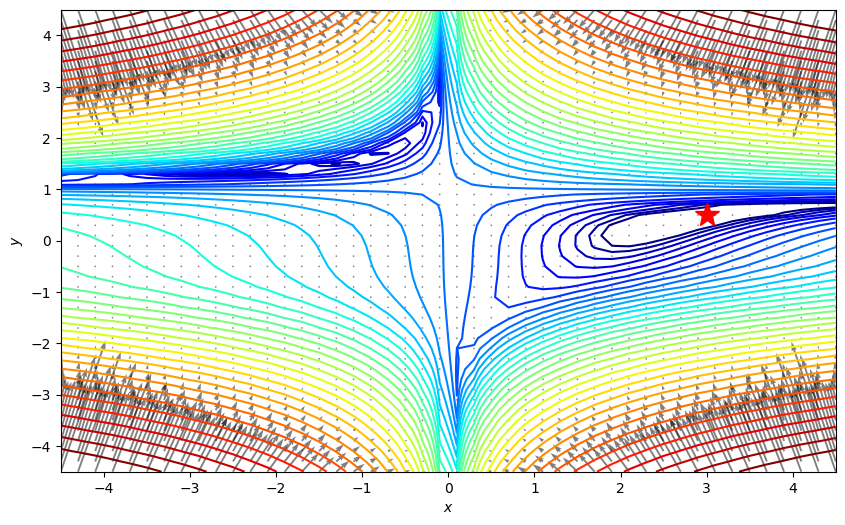

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(x, y, x - dz_dx, y - dz_dy, alpha=.5)
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

### Gradient-based Optimization

For the purposes of this demonstration, we use [SciPy's optimization methods](http://docs.scipy.org/doc/scipy/reference/optimize.html). It goes without saying that the code and patterns for producing these visualizations generalizes easily to other optimization tools and libraries.

We set the starting point as $(3, 4)$, since it is challenging for algorithms with a little too much momentum in the gradient descent update rule, as they may overshoot and end up in some local minima.

In [14]:
x0 = np.array([3., 4.])

Again, we use `autograd` to compute the gradients, and augment the function slightly to adhere to Scipy's optimization interface.

In [15]:
func = value_and_grad(lambda args: f(*args))

The method we use first is `Newton-CG`, and set the callback simply as `print`. Note that we can only do this in Python 3, where [`print` is an actual function](https://docs.python.org/3.0/whatsnew/3.0.html#print-is-a-function).

In [16]:
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=print)

[2.71113991 3.35161828]
[2.48008912 2.78955116]
[2.29965866 2.30123678]
[2.16373347 1.8756312 ]
[2.06741079 1.50235414]
[2.00766238 1.17079384]
[1.98485905 0.86972447]
[2.00511126 0.59071489]
[2.07692544 0.34891823]
[2.17857778 0.21644485]
[2.55966682 0.38003383]
[2.80228089 0.44954972]
[2.94477854 0.48765376]
[2.94564749 0.48601427]
[2.95359059 0.48810805]
[2.97113927 0.49269804]
[2.99870879 0.49976069]
[2.99999481 0.49999876]
[3.00000001 0.49999999]
[3.  0.5]
[3.  0.5]


In [17]:
dict(res)

{'fun': 2.5770606809684326e-18,
 'jac': array([8.13600382e-10, 1.86117137e-09]),
 'nfev': 21,
 'njev': 60,
 'nhev': 0,
 'status': 0,
 'success': True,
 'message': 'Optimization terminated successfully.',
 'x': array([3. , 0.5]),
 'nit': 21}

The results look plausibly good, but would be more convincing with some visualization. Let us define a new callback function that appends the intermediate values to a list instead of simply printing it.

In [18]:
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

We initialize the list with the starting value.

In [19]:
path_ = [x0]

In [20]:
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=make_minimize_cb(path_))

In [21]:
dict(res)

{'fun': 2.5770606809684326e-18,
 'jac': array([8.13600382e-10, 1.86117137e-09]),
 'nfev': 21,
 'njev': 60,
 'nhev': 0,
 'status': 0,
 'success': True,
 'message': 'Optimization terminated successfully.',
 'x': array([3. , 0.5]),
 'nit': 21}

We cast the list to a NumPy array and transpose it so it's easier and more natural to work with.

In [22]:
path = np.array(path_).T
path.shape

(2, 22)

### Static Quiver Plot of Path on 2D Contour Plot

Again, using the `quiver` method, but in a slightly different way than before, we can represent each step, it's length and direction, using the arrows.

(-4.5, 4.5)

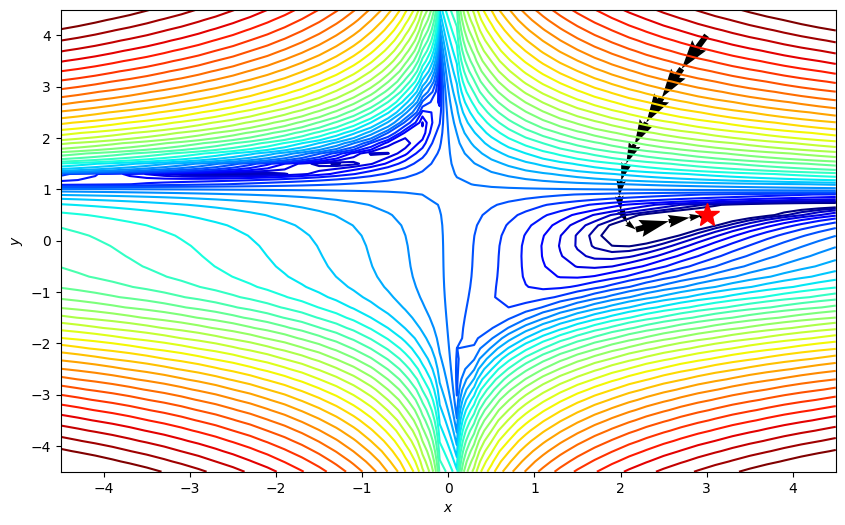

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

### Static Quiver Plot of Path on 3D Surface Plot

However, this is slightly less useful when plotted against a 3D surface plot...

(-4.5, 4.5)

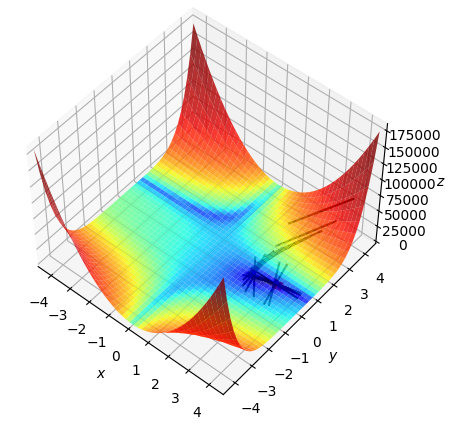

In [24]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], f(*path[::,:-1]), 
          path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], f(*(path[::,1:]-path[::,:-1])), 
          color='k')
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

### Animating Single Path on 2D Contour Plot

We can also animate the trajectory of the optimization algorithm using the excellent [FuncAnimation](http://matplotlib.org/api/animation_api.html#matplotlib.animation.FuncAnimation) class. First we draw the 2D contour plot as we did before, and initialize the `line` and `point` (which are [Line2D](http://matplotlib.org/api/lines_api.html#matplotlib.lines.Line2D) objects). Guides on how to use the `FuncAnimation` class can be found in tutorials such as [Jake Vanderplas' Matplotlib Animation Tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/), so we will not go into too much detail here.

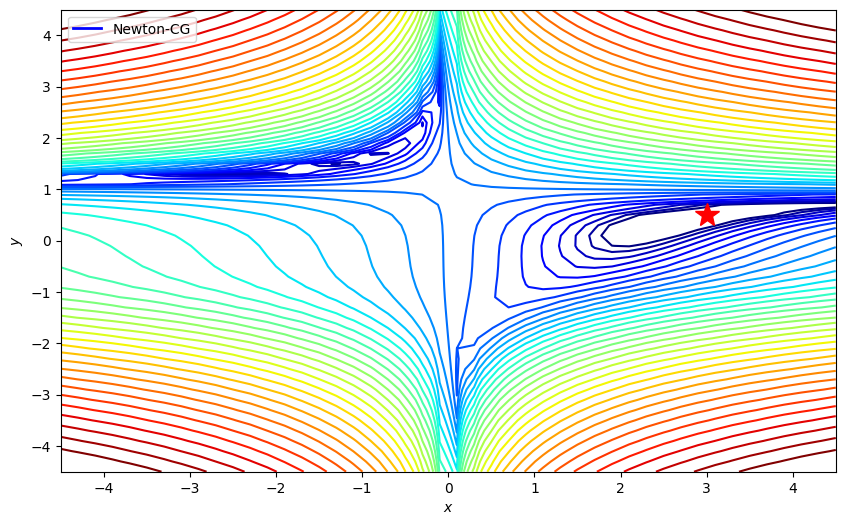

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=18)

line, = ax.plot([], [], 'b', label='Newton-CG', lw=2)
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')

In [26]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

We define our animation to draw the path up to $i$th intermediate point on the $i$th frame.

In [27]:
def animate(i):
    line.set_data(*path[::,:i])
    point.set_data(*path[::,i-1:i])
    return line, point

We define the total number of frames to be the total number of steps taken in the optimization and using [blitting](http://devosoft.org/making-efficient-animations-in-matplotlib-with-blitting/) so as to only redraw the parts of the animation that have changed.

In [28]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

We can embed the animation directly inside this notebook, as discussed in [my previous post](../embedding-matplotlib-animations-in-jupyter-notebooks).

In [29]:
HTML(anim.to_html5_video())

### Animating Single Path on 3D Surface Plot

Extending the above to 3-dimensions is quite trivial.

(-4.5, 4.5)

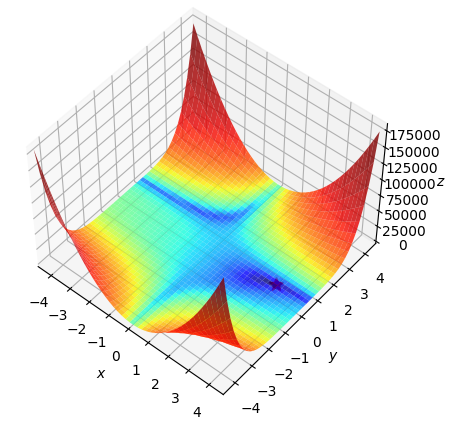

In [30]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

line, = ax.plot([], [], [], 'b', label='Newton-CG', lw=2)
point, = ax.plot([], [], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

We just have to make use of the `set_3d_properties` method for [Line3D](http://matplotlib.org/mpl_toolkits/mplot3d/api.html#mpl_toolkits.mplot3d.art3d.Line3D) objects to set the height of the points on the path.

In [31]:
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return line, point

In [32]:
def animate(i):
    line.set_data(path[0,:i], path[1,:i])
    line.set_3d_properties(f(*path[::,:i]))
    point.set_data(path[0,i-1:i], path[1,i-1:i])
    point.set_3d_properties(f(*path[::,i-1:i]))
    return line, point

In [33]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [34]:
HTML(anim.to_html5_video())

### Modularizing and Generalizing to Animate Multiple Paths Simultaneously

Instead of initializing the line and point in the global scope, and defining the animation callback functions to use those global variables, we can encapsulate everything in a closure. 

Or better yet, we could just create subclass of `FuncAnimation` that is initialized with a variable number of paths to plot. In the initialization method, we just create and save the list of `Line2D` objects as attributes, and define animation callback methods that use these attributes.

In [35]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

We can extend this to 3-dimensions quite easily:

In [36]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

Note that `TrajectoryAnimation3D` is defined as an altogether different subclass of `FuncAnimation` here. A more elegant approach would be to subclass the `TrajectoryAnimation` class defined above, but this would make this exposition much less readable.

Additionally, note that we don't plot the leading point marker here, since this tends to clutter up the visualization on the 3D surface plots.

### SciPy' Gradient-based Optimization Algorithms

Now let's take these newly defined classes out for a spin! Let us simultaneously animate SciPy's gradient-based optimization algorithms.

In [37]:
methods = [
    "CG",
#   "BFGS",
    "Newton-CG",
    "L-BFGS-B",
    "TNC",
    "SLSQP",
#   "dogleg",
#   "trust-ncg"
]

We do some partial function application here to reduce the amount of code required..

In [38]:
minimize_ = partial(minimize, fun=func, x0=x0, jac=True, bounds=[(xmin, xmax), (ymin, ymax)], tol=1e-20)

Initialize the trajectories

In [39]:
paths_ = defaultdict(list)
for method in methods:
    paths_[method].append(x0)

We expected these warnings, and can safely ignore them here.

In [40]:
results = {method: minimize_(method=method, callback=make_minimize_cb(paths_[method])) for method in methods}

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method Newton-CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [41]:
paths = [np.array(paths_[method]).T for method in methods]

In [42]:
zpaths = [f(*path) for path in paths]

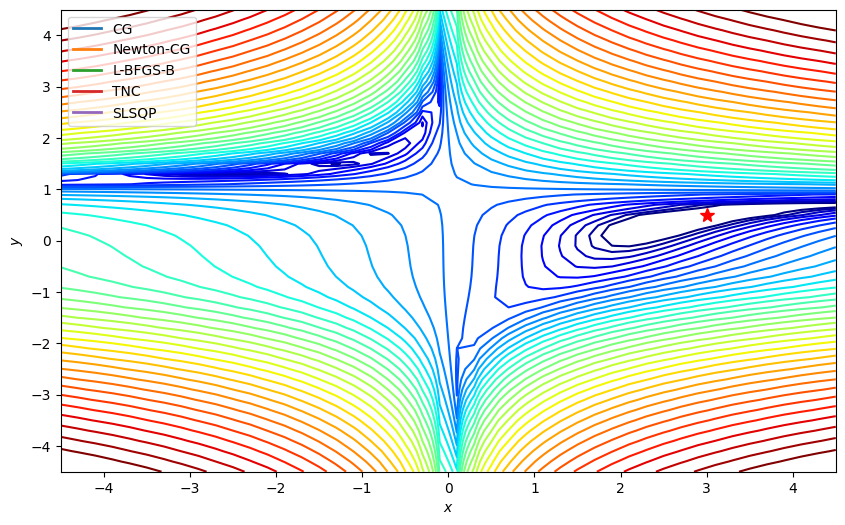

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [44]:
HTML(anim.to_html5_video())

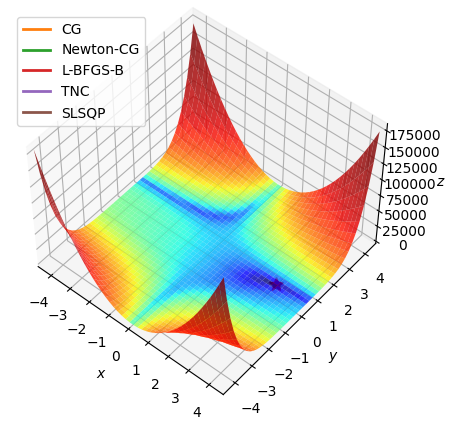

In [45]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [46]:
HTML(anim.to_html5_video())

Having the `TrajectoryAnimation` class at our disposal makes it incredibly simple to not only visualize, but animate optimization procedures, and allows us to better understand and be able to visually debug the optimization problems and algorithms we are working with. 

Furthermore, the fact that `TrajectoryAnimation` is a subclass of `FunAnimation` means we have the flexibility of exporting and presenting these animations in a variety of formats, e.g. exporting as GIFs, embedding them in Jupyter Notebooks as HTML5 videos. This can make our presentations far more compelling.

In future posts in this series, we will demonstrate these methods on other objective functions, other optimization algorithms in other libraries such as [TensorFlow](https://www.tensorflow.org/versions/r0.8/api_docs/python/train.html#optimizers), and generalize to higher-dimensional problems.